In [61]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("FinalCoursework") \
    .getOrCreate()

sc = spark.sparkContext

Read the File

In [62]:
dir_path="/mnt/data/project-data/2020tweets"
# <FILL-IN WITH YOUR CODE>
df_trump = spark.read.option("multiline", True).csv("data/hashtag_donaldtrump.csv", header=True, inferSchema=True)
df_biden = spark.read.option("multiline", True).csv("data/hashtag_joebiden.csv", header=True, inferSchema=True)
# <FILL-IN WITH YOUR CODE>

In [63]:
def transer_data_type(data):
  data = data.withColumn("likes", data["likes"].cast("int"))
  data = data.withColumn("retweet_count", data["retweet_count"].cast("int"))
  data = data.withColumn("user_followers_count", data["user_followers_count"].cast("int"))
  data = data.withColumn("lat", data["lat"].cast("float"))
  data = data.withColumn("long", data["long"].cast("float"))
  return data

df_trump = transer_data_type(df_trump)
df_biden = transer_data_type(df_biden)

In [64]:
#Dropping columns
remove_columns = ['created_at', 'tweet_id', 'user_id', 'user_screen_name', 'user_join_date', 'collected_at']
df_trump = df_trump.drop(*remove_columns)
df_biden = df_biden.drop(*remove_columns)

#Dropping rows with na values
df_trump = df_trump.na.drop()
df_biden = df_biden.na.drop()

Compared the number between biden and trump

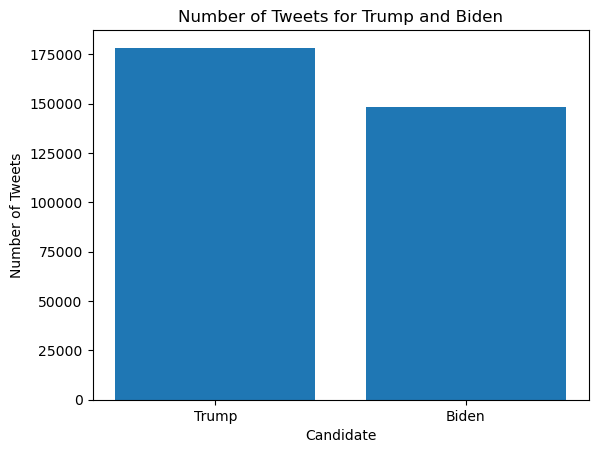

In [65]:
import matplotlib.pyplot as plt

# Create a bar plot
plt.bar(['Trump', 'Biden'], [df_trump.count(), df_biden.count()])
plt.xlabel('Candidate')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets for Trump and Biden')
plt.show()

In [66]:
from pyspark.sql.functions import lit

#Adding a presidents column where 0 represents trump and 1 represents biden. This will turn it into a classification problem
df_trump = df_trump.withColumn('President', lit(0))
df_biden = df_biden.withColumn('President', lit(1))

#Merging the 2 datasets
df = df_trump.union(df_biden)

In [67]:
df.show(5)

+--------------------+-----+-------------+-------------------+--------------------+--------------------+--------------------+--------------------+---------+-----------+-----------------+--------------------+-------------+--------------------+----------+---------+
|               tweet|likes|retweet_count|             source|           user_name|    user_description|user_followers_count|       user_location|      lat|       long|             city|             country|    continent|               state|state_code|President|
+--------------------+-----+-------------+-------------------+--------------------+--------------------+--------------------+--------------------+---------+-----------+-----------------+--------------------+-------------+--------------------+----------+---------+
|#Trump: As a stud...|    2|            1|    Twitter Web App|              snarke|Will mock for foo...|                1185|            Portland| 45.52025|-122.674194|         Portland|United States of ...|N

Pre-processing

(1)we remove stop_words,special punction and url from the text

In [68]:
import re,string
# This code defines a function named "tokenize" that tokenizes the input text.
# It removes special characters, converts the text to lowercase, and removes stopwords and punctuation.
# The resulting tokens are added to a list and returned.

# This code defines a list of stopwords to be removed from the text.
stopwords = [u'rt', u're', u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your',
             u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers',
             u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what',
             u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were',
             u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a',
             u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by',
             u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after',
             u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under',
             u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all',
             u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u'not',
             u'only', u'own', u'same', u'so', u'than', u'too', u'very', u's', u't', u'can', u'will', u'just', u'don',
             u'should', u'now']
def tokenize(text):
    # Remove URLs
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*(),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Remove special characters
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Split text into tokens and filter out stopwords, single characters, and '``'
    tokens = [word for word in text.split() if word not in stopwords and len(word) > 1 and word != '``']
    
    return tokens

In [69]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType,IntegerType

# Define UDF to tokenize the tweet attribute
@udf(returnType=ArrayType(StringType()))
def tokenize_tweet(text):
    # Write code here to tokenize the tweet using the desired method/function
    tokens = tokenize(text)
    return tokens

# Add a new column 'Tokens' to the DataFrame 'df' by calling the 'tokenize_tweet' UDF on the 'tweet' column
df=df.withColumn('Tokens', tokenize_tweet(df['tweet']))

In [70]:
df.show(3)

+--------------------+-----+-------------+------------------+--------------------+--------------------+--------------------+-----------------+---------+-----------+----------+--------------------+-------------+--------------------+----------+---------+--------------------+
|               tweet|likes|retweet_count|            source|           user_name|    user_description|user_followers_count|    user_location|      lat|       long|      city|             country|    continent|               state|state_code|President|              Tokens|
+--------------------+-----+-------------+------------------+--------------------+--------------------+--------------------+-----------------+---------+-----------+----------+--------------------+-------------+--------------------+----------+---------+--------------------+
|#Trump: As a stud...|    2|            1|   Twitter Web App|              snarke|Will mock for foo...|                1185|         Portland| 45.52025|-122.674194|  Portland|Uni

(2)To use word2Vec,we download the pre-trained word2Vec model and broatcast them to the worker computer

In [71]:
from pyspark import SQLContext
sqlContext = SQLContext(sc)
lookup = sqlContext.read.parquet("word2vecM_simple/data").alias("lookup")
lookup.printSchema()
lookup_bd = sc.broadcast(lookup.rdd.collectAsMap())

root
 |-- word: string (nullable = true)
 |-- vector: array (nullable = true)
 |    |-- element: float (containsNull = true)


C:\Users\ALLEN AN\AppData\Roaming\Python\Python311\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


(3)doc2vec methos is iterate each comment and tranfer the comment into an array which contains many word vectors

In [72]:
# Change the return type of the function from ndarray to list
def doc2vec(document):
    doc_vec = [0] * 100
    tot_words = 0
    
    for word in document:
        try:
            vec = lookup_bd.value.get(word)
            if vec is not None:
                doc_vec = [a + b + 1 for a, b in zip(doc_vec, vec)]
                tot_words += 1
        except:
            continue
    
    if tot_words > 0:
        doc_vec = [a / float(tot_words) for a in doc_vec]
    
    return doc_vec

In [73]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType,FloatType

# Define UDF to calculate the vector representation of the document by summing up the feature values of each word in the document
@udf(returnType=ArrayType(FloatType()))
def doc_to_vec(tokens):
    token=tokenize(tokens)
    # Write code here to calculate the vector representation of the document using the desired method/function
    vector = doc2vec(token)
    return vector
  
# Add a new column 'DocVec' to the DataFrame 'df' by calling the 'doc_to_vec' UDF on the 'Tokens' column
df=df.withColumn('DocVec', doc_to_vec(df['tweet']))

In [74]:
df.select("DocVec").show(5)

+--------------------+
|              DocVec|
+--------------------+
|[1.0615877, 1.028...|
|[1.0815177, 1.128...|
|[1.054553, 0.9993...|
|[0.9313747, 0.990...|
|[1.2355838, 1.145...|
+--------------------+


（4）caculate polarity with sentiment analysis

In [75]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
sc.broadcast(sia)

def calculate_sentiment(text):
    #sia = SentimentIntensityAnalyzer()
    if isinstance(text, list):
        text = ' '.join(text)
    sentiment_scores = sia.polarity_scores(text)['compound']

    '''if(sentiment_scores>0):
      sentiment_scores=1
    elif(sentiment_scores<0):
      sentiment_scores=-1
    else:
      sentiment_scores=0'''
    return sentiment_scores

[nltk_data] Downloading package vader_lexicon to C:\Users\ALLEN
[nltk_data]     AN\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [76]:
from pyspark.sql.types import *

# Define UDF to tokenize the tweet attribute
@udf(returnType=FloatType())
def tokenize_tweet(text):
    # Write code here to tokenize the tweet using the desired method/function
    tokens = tokenize(text)
    sent=calculate_sentiment(tokens)
    return sent

# Add a new column 'Tokens' to the DataFrame 'df' by calling the 'tokenize_tweet' UDF on the 'tweet' column
df=df.withColumn('polarity', tokenize_tweet(df['tweet']))


In [77]:
df.select("polarity").show(3)

+--------+
|polarity|
+--------+
|  0.3612|
|     0.0|
| -0.1027|
+--------+


(5)Labeled the cloassfication
if polarity>0 sent=1
if polarity=0 sent=0
if polarity<0 sent=-1

In [78]:
from pyspark.sql.functions import when, col

df = df.withColumn('sent', when(col('polarity') > 0, 1)
                        .when(col('polarity') <= 0, -1)
                        .otherwise(0))

In [79]:
df.show(5)

+--------------------+-----+-------------+-------------------+--------------------+--------------------+--------------------+--------------------+---------+-----------+-----------------+--------------------+-------------+--------------------+----------+---------+--------------------+--------------------+--------+----+
|               tweet|likes|retweet_count|             source|           user_name|    user_description|user_followers_count|       user_location|      lat|       long|             city|             country|    continent|               state|state_code|President|              Tokens|              DocVec|polarity|sent|
+--------------------+-----+-------------+-------------------+--------------------+--------------------+--------------------+--------------------+---------+-----------+-----------------+--------------------+-------------+--------------------+----------+---------+--------------------+--------------------+--------+----+
|#Trump: As a stud...|    2|            

Build Train_Data and Split Test and train Data

In [133]:
seed = 654321
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

# Define a UDF to convert array of float to Vectors
array_to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())

# Apply the UDF to the DocVec column
df = df.withColumn("DocVec", array_to_vector("DocVec"))
df=df.drop('tweet','source','user_name','user_description','user_location','city','country','continent','state','state_code','Tokens')

train_df, test_df = df.randomSplit([0.7, 0.3], seed=seed)

train_df.cache()
test_df.cache()

print("Number of rows in training set:", train_df.count())
print("Number of rows in test set:", test_df.count())


Number of rows in training set: 228605
Number of rows in test set: 97948


In [134]:
df.show(5)

+-----+-------------+--------------------+---------+-----------+---------+--------------------+--------+----+
|likes|retweet_count|user_followers_count|      lat|       long|President|              DocVec|polarity|sent|
+-----+-------------+--------------------+---------+-----------+---------+--------------------+--------+----+
|    2|            1|                1185| 45.52025|-122.674194|        0|[1.06158768587435...|  0.3612|   1|
|    4|            3|                5393|38.894993|  -77.03656|        0|[1.08151774201542...|     0.0|  -1|
|    0|            0|                1396| 41.87556|  -87.62442|        0|[1.05455307082997...| -0.1027|  -1|
|    3|            5|                 496|32.717422| -117.16277|        0|[0.93137471253673...|  0.5267|   1|
|    2|            0|                2755|55.953346|  -3.188375|        0|[1.23558372259140...| -0.3818|  -1|
+-----+-------------+--------------------+---------+-----------+---------+--------------------+--------+----+


Create a PipeLine with Spark ML <br>
(1) Please use RandomForest model <br>
(2) train features is doc2vec,likes,retweet_count,user_followers_count <br>
(3) train target label is sent

In [165]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("DT Pipeline") \
    .getOrCreate()

In [176]:
from pyspark.ml.feature import VectorAssembler,StringIndexer
feature_columns = ['likes', 'retweet_count', 'user_followers_count','sent','DocVec','polarity','lat','long']
#feature_columns=df.columns
print(feature_columns)
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
# Index the label column "President" if it's categorical
label_indexer = StringIndexer(inputCol="President", outputCol="label")

['likes', 'retweet_count', 'user_followers_count', 'sent', 'DocVec', 'polarity', 'lat', 'long']


In [177]:
from pyspark.ml.classification import DecisionTreeClassifier

# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label",maxDepth=10)

In [178]:
from pyspark.ml import Pipeline

# Set up the pipeline
pipeline = Pipeline(stages=[assembler, label_indexer, dt])

In [179]:
# Train the model
model = pipeline.fit(train_df)

In [180]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Make predictions
predictions = model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")
print("dd")

Test Accuracy: 0.5765814513823662
